In [3]:
import datetime
from flickplay.mongo import get_mongo_db_obj
from flickplay.get_connections import get_alchemy_con, get_pymysql_con
from flickplay.utils import timer_func
import os
import pandas as pd
import numpy as np
import sys

wd='/Users/allen/Developer/clo/flickplay/mixpanel-events'
os.chdir(wd)
print(os.getcwd(), wd==os.getcwd())
db, conp, con = get_mongo_db_obj(), get_pymysql_con(), get_alchemy_con()


@timer_func
def get_nfts():
    print('Getting NFTs from experiences')
    nfts = db.experiences.find({'nft': True, 'certified': True})
    return pd.DataFrame.from_records(nfts)

nfts=get_nfts()
certified_nft_ids = nfts._id.values
certified_nft_in_blockchainwallet_ids = nfts[~pd.isnull(nfts.nftOwnerWalletAddress)]


@timer_func
def get_recordings():
    print('Getting recordings from recordings')
    return pd.DataFrame.from_records(db.recordings.find())

# dr=get_recordings()

@timer_func
def get_certified_recordings(dr=dr):
    print('Construct DataFrame of Certified Recordings (dcr)')
    dcrids = []
    for idx, row in dr.iterrows():
        recording_has_certified_nft = False
        for e in row.experiences:
            if e in certified_nft_ids:
                dcrids.append(row._id)
                continue
    dcr = dr[dr._id.isin(dcrids)]
    dcr['month'] = dcr['created'].apply(lambda x: x.date().month)
    dcr['year'] = dcr.created.apply(lambda x: x.date().year)
    dcr['month'] = dcr.created.apply(lambda x: x.date().month)
    dcr['date'] = dcr.created.apply(lambda x: str(x.date().year)+'-'+str(x.date().month))
    return dcr

@timer_func
def get_users():
    print('Getting users from users')
    return pd.DataFrame(db.users.find())



/Users/allen/Developer/clo/flickplay/mixpanel-events True
Getting NFTs from experiences
Function 'get_nfts' executed in 142.8244s


NameError: name 'dr' is not defined

In [ ]:
dcr=get_certified_recordings()
users = get_users()

In [3]:
# nfts

In [ ]:
@timer_func
def get_recording_aggregates(dcr=dcr):
    recs = []
    for year in [2020,2021,2022,2023]:
        for month in [i+1 for i in range(12)]:
            if year == 2020:
                if month < 12:
                    continue
            if year == 2023:
                if month > 1:
                    continue
            date = str(year)+'-'+str(month)
            nrecordings = len(dcr[(dcr.year==year) & (dcr.month==month)])
            recordings  = list(set(dcr[(dcr.year==year) & (dcr.month==month)]._id))
            nusers      = len(set(dcr[(dcr.year==year) & (dcr.month==month)].user))
            users = list(set(dcr[(dcr.year==year) & (dcr.month==month)].user))
            rec = {
                'date': date,
                'year': year,
                'month': month,
                'recordings': recordings,
                'n_recordings': nrecordings,
                'n_users': nusers,
                'users': users
            }
            recs.append(rec)
    aggregates = pd.DataFrame.from_records(recs)
    return aggregates

aggregates = get_recording_aggregates()
aggregates

In [ ]:
aggregates[['date','n_recordings','n_users']]

Text(0.5, 1.0, 'Videos with certified NFT created by Month')

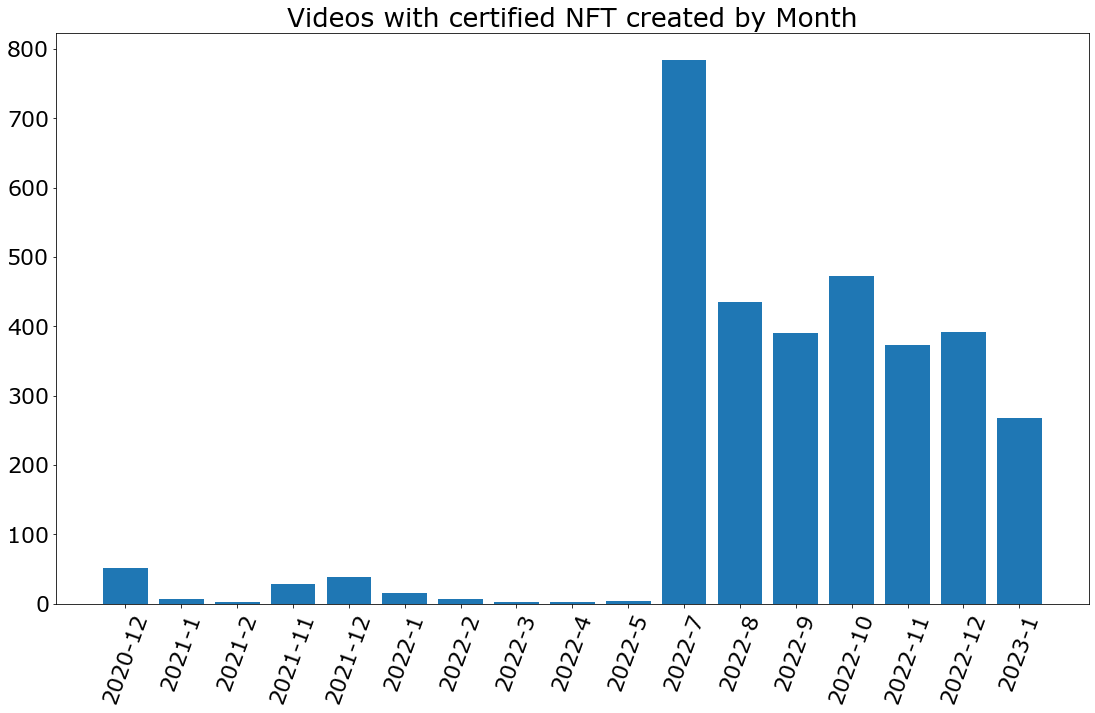

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

font = {'family' : 'verdana',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)

d = dcr[['month', 'year', 'user']].groupby(['year','month']).count()
dd = d.copy().reset_index()

x,y=[],[]

years, months = [2020,2021,2022,2023], [ i+1 for i in range(12) ]

yrmos = { str(yr)+'-'+str(mo) for yr in years for mo in months }

for idx, row in dd.iterrows():
    yrmo = str(row.year)+'-'+str(row.month)
    if yrmo not in yrmos:
        y.append(0)
    else:
        y.append(row.user)
    x.append(yrmo)
    
import matplotlib.pyplot as plt


plt.bar(x, y)
plt.xticks(rotation=70)
plt.title('Videos with certified NFT created by Month')

Text(0.5, 1.0, 'Videos with certified NFT created by Month')

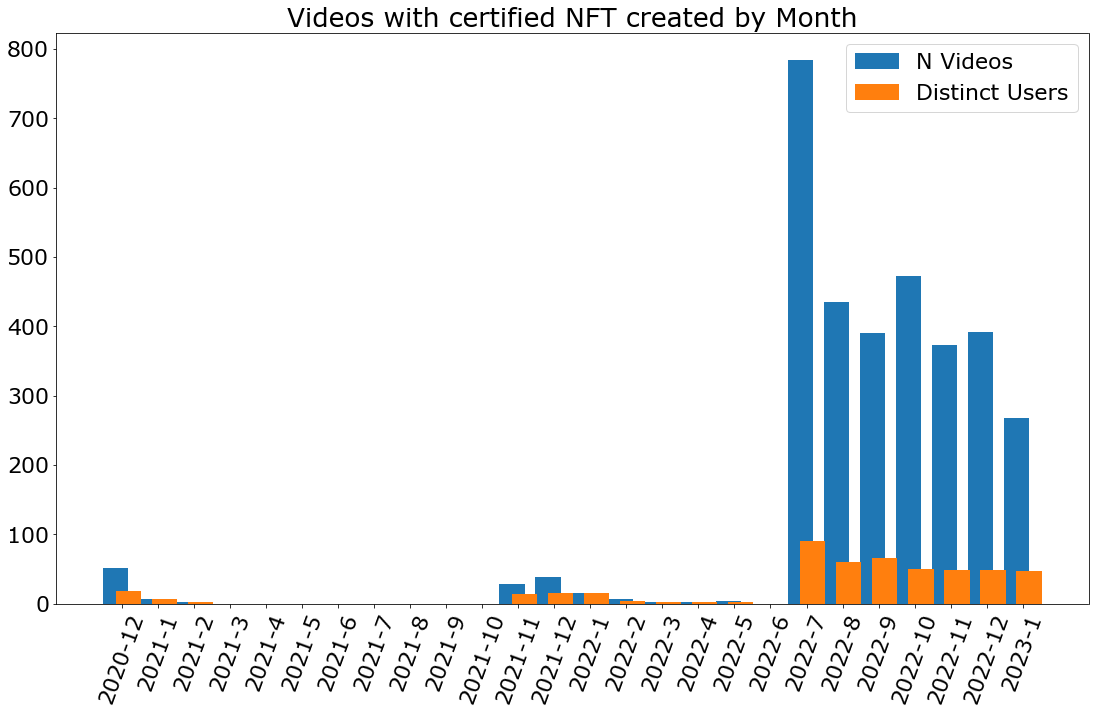

In [7]:
import datetime

dcrr = dcr.copy()
du = dd.copy()

labels,y_users,y_recordings=aggregates.date.values,aggregates.n_users.values, aggregates.n_recordings.values
years, months = [2021,2022], [ i+1 for i in range(12) ]


yrmos = { str(yr)+'-'+str(mo) for yr in years for mo in months }
yrmos.add('2020-12')
yrmos.add('2023-1')
for idx, row in dd.iterrows():
    yrmo = str(row.year)+'-'+str(row.month)
    if yrmo not in yrmos:
        y.append(0)
    else:
        y.append(row.user)
    x.append(yrmo)
    


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

font = {'family' : 'verdana',
       # 'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)

pos = np.arange(len(labels))
width=0.35

r = ax.bar(pos-width/2, y_recordings, width*2,label='N Videos')
u = ax.bar(pos+width/2, y_users, width*2,label='Distinct Users')

ax.set_xticks(pos)
ax.set_xticklabels(labels)
plt.xticks(rotation=70)

ax.set_title('Videos with certified NFT created by Month')
plt.legend()
plt.xticks(rotation=70)
plt.title('Videos with certified NFT created by Month')



In [8]:
aggregates

,date,year,month,recordings,n_recordings,n_users,users
0,2020-12,2020,12,"[5fdd6c1d9b7c6d4b8e43d23e, 5fde87aa55c01381d22...",51,18,"[5fa1a5e53633e9183636cdbd, 5f3446b8b16e487e29d..."
1,2021-1,2021,1,"[5ff485e29600a528c8bf33e4, 5ffdcf7b68c01a9921a...",7,7,"[5eb83c832f927b8f72f5d0c2, 5f978f548a3e7f23701..."
2,2021-2,2021,2,"[602f0c72a1ee172fd93bb02a, 602ab6f1fc277e122f2...",2,2,"[602a974ec3f5340a636d9a88, 5ecaf395e42ea917daf..."
3,2021-3,2021,3,[],0,0,[]
4,2021-4,2021,4,[],0,0,[]
5,2021-5,2021,5,[],0,0,[]
6,2021-6,2021,6,[],0,0,[]
7,2021-7,2021,7,[],0,0,[]
8,2021-8,2021,8,[],0,0,[]
9,2021-9,2021,9,[],0,0,[]


In [40]:
@timer_func
def get_process_recordings(dcr=None, dr=None):
    if dr is None:
        dr = get_recordings()
    if dcr is None:
        dcr=get_certified_recordings(dr=dr)
    recordings_with_certified_nft = dcr
    print('Processing Recordings')
    dr['hasCertifiedNFT'] = [ True if row._id in set(recordings_with_certified_nft._id.values) else False for idx, row in dr.iterrows() ]
    return dr


@timer_func
def get_process_users(dcr=dcr,
                      dr=dr,
                      users=None):
    
    recordings_with_certified_nft = dcr
    if users is None:
        print('Fetching Users')
        users = get_users()
    print('Processing User hasCertifiedNFT')
    users['ownsCertifiedNFT'] = [ True if row._id in  set(recordings_with_certified_nft.user.values)  else False for idx, row in users.iterrows() ]
    # print('Processing users x recordings')
    # users['recordings'] = [[]]*len(users)
    # users['recordingsWithCertifiedNFT'] = [[]]*len(users)
    # for idx, row in users.iterrows():
    #     u = row._id
    #     users.at[idx, 'recordings'] = list(dr[dr.user == u]._id.values)
    #     users.at[idx, 'recordingsWithCertifiedNFT'] =  list(dcr[dcr.user == u]._id.values)
    return users

def process_reg_type(user):
    if user.anonymous:
        return 'anonymous'
    elif user.createdThroughConnectWallet:
        return 'wallet connect'
    elif not np.isnan(user.appleId):
        return 'apple'
    else:
        return 'regular'

def get_registration_filter(kind='apple'):
    if kind not in ('apple', 'walletConnect', 'regular', 'anonymous'):
        raise ValueError(f"kind must be one of 'apple', 'walletConnect', 'regular', 'anonymous'")
    if kind == 'apple':
        return {'appleId': {'$ne': None}}
    elif kind == 'walletConnect':
        return {'createdThroughConnectWallet': True}
    elif kind == 'anonymous':
        return {'anonymous': True}
    else:
        return  {'anonymous': False, 'createdThroughConnectWallet': False, 'appleId': None}
    
@timer_func
def get_users_by_reg_type(kind='apple'):
    reg_filter = get_registration_filter(kind=kind)
    return pd.DataFrame.from_records(db.users.find(reg_filter))


# dr = get_process_recordings()
users = get_process_users()
apple = get_users_by_reg_type('apple')
regular = get_users_by_reg_type('regular')
walletConnect = get_users_by_reg_type('walletConnect')
anonymous = get_users_by_reg_type('anonymous')

users_by_reg_type = {
    'all': users,
    'apple': apple,
    'regular': regular,
    'walletConnect': walletConnect,
    'anonymous': anonymous}

userids_by_reg_type = { k:df._id.values for k, df in users_by_reg_type.items() }

[ print(k, len(users_by_reg_type[k])) for k in users_by_reg_type.keys() ]

import sys

users['appleSignup'] = users._id.apply(lambda x:  x in userids_by_reg_type['apple'])
users['walletSignup'] = users._id.apply(lambda x:  x in userids_by_reg_type['walletConnect'])
users['regularSignup'] = users._id.apply(lambda x: x in userids_by_reg_type['regular'])
users['user_id'] = users._id.apply(lambda x: str(x))



In [113]:
# u=u.drop(columns='anonymous')
# u['anonymous'] = users['anonymous']


u = users[['_id','user_id', 'username', 
           'appleSignup', 'walletSignup', 'regularSignup', 'anonymous','ownsCertifiedNFT',
       #'profileImage', 'googleId', 'facebookId', 'appleId', 'email',
       'name', 'age', 'gender', 
       #'bio', 
       'countryCode', 'phone', 
       #'phoneHash',
       'role', 'isUser', 'isAdmin', 
       #'loginCount', 'deleted', 
       'active', 
       #'verified', 
       'followingCount', 'followersCount', 'likesCount',
       'pointsCollected', 'flicksTotal', 'lastHomeFeedDate', 
       #'pointsLastFlick',
       'lastNotificationDate', 
       #'lang', 'presaleCode', 'isValidPresaleCode',
       #'blockedUsers', 
       #'salt', 'hashedPassword', 
       'created', 'updated', 'lastUsed', 
       #'profilePoints', 'pushToken', 
       'allTimePoints','viewsCount', 
       #'overrideViewsCount', 
       'device', 'ios', 
       'wasAnonymous', 'allowMap', 'allowVideoMap', 'allowPinVideo',
       'collectionsCount', 'collectionsSavedCount', 
       #'tipsBalance', 'allTips',
       'cameraPermission', 'locationPermission', 'notificationPermission',
       'isMapCreator', 'allowAutopopulation', 'isCertified', 
       #'pushTokens',
       'allTimeLikes', 'isMapCreatorDelete', 
       #'pushCounterFollowing', 'pushCounterWallet', 'spotCount', 'isBlocked', 'lastSyncDate',
       'createdThroughConnectWallet', 
       #'isExperienceCreator', 'nftCreator', 'flicks', 'yellowButtonCollected', 'walls', 'chameleonButton', 
       'sex', 'flicksCollected', 
       #'pushCounterLikes', 'avatar', 'profileCover', 'keychainToken', 'lastSpotRecordingId', 'mapThumbnail', 'lastTipsDate',
       #'deviceId', '__v', 'profileCoverV2', 'profileCoverVideoId',
       #'profileCoverOffsetMultiplier', 'idfa', 'idfv'
      ]]
u

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,ownsCertifiedNFT,name,age,...,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,isMapCreatorDelete,createdThroughConnectWallet,sex,flicksCollected
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,False,False,True,False,True,,-1,...,authorizedWhenInUse,denied,False,False,False,440.0,False,False,NaN,NaN
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,True,False,False,False,False,Juliana Lima,30,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,True,False,False,NaN,False,App Reviewthreefiveone,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,False,False,False,False,False,Beni,25,...,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,m,"{'point': 0, 'experience': 0, 'reward': 0}"
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,True,False,False,False,False,user,-1,...,NaN,NaN,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64830,63d00e724ba7a9e83b095747,63d00e724ba7a9e83b095747,anonymous-18220577,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64831,63d00fd40c664282cefff647,63d00fd40c664282cefff647,anonymous-39203941,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64832,63d01172bf38986fcf181b30,63d01172bf38986fcf181b30,anonymous-17847718,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64833,63d0125077ac003369a41c8d,63d0125077ac003369a41c8d,anonymous-63079000,False,False,False,True,False,None,-1,...,None,None,False,False,False,0.0,False,False,NaN,NaN


all 64835
apple 2766
regular 2801
walletConnect 591
anonymous 49673


[None, None, None, None, None]

In [42]:
# pd.DataFrame.from_records(db.users.find({'createdThroughConnectWallet': True}))

In [43]:
# users[users.createdThroughConnectWallet==True]

In [11]:
userids_by_reg_type = { k:df._id.values for k, df in users_by_reg_type.items() }
# userids_by_reg_type['all']

array([ObjectId('5ecafc014fb0f51a8e489a6c'),
       ObjectId('5f016e087b8da9fc10f75104'),
       ObjectId('5f085555476b26bb36e8a3de'), ...,
       ObjectId('63d01172bf38986fcf181b30'),
       ObjectId('63d0125077ac003369a41c8d'),
       ObjectId('63d0186d0c6642603e00148e')], dtype=object)

In [12]:
print(len(users_by_reg_type['all']), sum([ len(users_by_reg_type[k]) for k in users_by_reg_type.keys() if k!='all' ]))

64835 55831


In [44]:
import sys

users['appleSignup'] = users._id.apply(lambda x:  x in userids_by_reg_type['apple'])
users['walletSignup'] = users._id.apply(lambda x:  x in userids_by_reg_type['walletConnect'])
users['regularSignup'] = users._id.apply(lambda x: x in userids_by_reg_type['regular'])
users['user_id'] = users._id.apply(lambda x: str(x))



u = users[['_id','user_id', 'username', 
           'appleSignup', 'walletSignup', 'regularSignup', 'anonymous','ownsCertifiedNFT',
       #'profileImage', 'googleId', 'facebookId', 'appleId', 'email',
       'name', 'age', 'gender', 
       #'bio', 
       'countryCode', 'phone', 
       #'phoneHash',
       'role', 'isUser', 'isAdmin', 
       #'loginCount', 'deleted', 
       'active', 
       #'verified', 
       'followingCount', 'followersCount', 'likesCount',
       'pointsCollected', 'flicksTotal', 'lastHomeFeedDate', 
       #'pointsLastFlick',
       'lastNotificationDate', 
       #'lang', 'presaleCode', 'isValidPresaleCode',
       #'blockedUsers', 
       #'salt', 'hashedPassword', 
       'created', 'updated', 'lastUsed', 
       #'profilePoints', 'pushToken', 
       'allTimePoints','viewsCount', 
       #'overrideViewsCount', 
       'device', 'ios', 
       'anonymous', 'wasAnonymous', 'allowMap', 'allowVideoMap', 'allowPinVideo',
       'collectionsCount', 'collectionsSavedCount', 
       #'tipsBalance', 'allTips',
       'cameraPermission', 'locationPermission', 'notificationPermission',
       'isMapCreator', 'allowAutopopulation', 'isCertified', 
       #'pushTokens',
       'allTimeLikes', 'isMapCreatorDelete', 
       #'pushCounterFollowing', 'pushCounterWallet', 'spotCount', 'isBlocked', 'lastSyncDate',
       'createdThroughConnectWallet', 
       #'isExperienceCreator', 'nftCreator', 'flicks', 'yellowButtonCollected', 'walls', 'chameleonButton', 
       'sex', 'flicksCollected', 
       #'pushCounterLikes', 'avatar', 'profileCover', 'keychainToken', 'lastSpotRecordingId', 'mapThumbnail', 'lastTipsDate',
       #'deviceId', '__v', 'profileCoverV2', 'profileCoverVideoId',
       #'profileCoverOffsetMultiplier', 'idfa', 'idfv'
      ]]
u

In [131]:
unclassified_registered = u[(u.anonymous==False) & (u.appleSignup==False) & (u.walletSignup==False) & (u.regularSignup==False)]

In [132]:
unclassified_registered.to_csv('/Users/allen/Desktop/unclassified_users.csv',index=False)

In [45]:
# users = get_process_users(dr=dr,dcr=dcr,users=users)

Processing User hasCertifiedNFT
Function 'get_process_users' executed in 59.4095s


In [54]:
u = users[['_id','user_id', 'username', 
           'appleSignup', 'walletSignup', 'regularSignup', 'anonymous','ownsCertifiedNFT',
       #'profileImage', 'googleId', 'facebookId', 'appleId', 'email',
       'name', 'age', 'gender', 
       #'bio', 
       'countryCode', 'phone', 
       #'phoneHash',
       'role', 'isUser', 'isAdmin', 
       #'loginCount', 'deleted', 
       'active', 
       #'verified', 
       'followingCount', 'followersCount', 'likesCount',
       'pointsCollected', 'flicksTotal', 'lastHomeFeedDate', 
       #'pointsLastFlick',
       'lastNotificationDate', 
       #'lang', 'presaleCode', 'isValidPresaleCode',
       #'blockedUsers', 
       #'salt', 'hashedPassword', 
       'created', 'updated', 'lastUsed', 
       #'profilePoints', 'pushToken', 
       'allTimePoints','viewsCount', 
       #'overrideViewsCount', 
       'device', 'ios', 
       'anonymous', 'wasAnonymous', 'allowMap', 'allowVideoMap', 'allowPinVideo',
       'collectionsCount', 'collectionsSavedCount', 
       #'tipsBalance', 'allTips',
       'cameraPermission', 'locationPermission', 'notificationPermission',
       'isMapCreator', 'allowAutopopulation', 'isCertified', 
       #'pushTokens',
       'allTimeLikes', 'isMapCreatorDelete', 
       #'pushCounterFollowing', 'pushCounterWallet', 'spotCount', 'isBlocked', 'lastSyncDate',
       'createdThroughConnectWallet', 
       #'isExperienceCreator', 'nftCreator', 'flicks', 'yellowButtonCollected', 'walls', 'chameleonButton', 
       'sex', 'flicksCollected', 
       #'pushCounterLikes', 'avatar', 'profileCover', 'keychainToken', 'lastSpotRecordingId', 'mapThumbnail', 'lastTipsDate',
       #'deviceId', '__v', 'profileCoverV2', 'profileCoverVideoId',
       #'profileCoverOffsetMultiplier', 'idfa', 'idfv'
      ]]
u

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,ownsCertifiedNFT,name,age,...,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,isMapCreatorDelete,createdThroughConnectWallet,sex,flicksCollected
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,False,False,True,False,True,,-1,...,authorizedWhenInUse,denied,False,False,False,440.0,False,False,NaN,NaN
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,True,False,False,False,False,Juliana Lima,30,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,True,False,False,NaN,False,App Reviewthreefiveone,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,False,False,False,False,False,Beni,25,...,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,m,"{'point': 0, 'experience': 0, 'reward': 0}"
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,True,False,False,False,False,user,-1,...,NaN,NaN,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64830,63d00e724ba7a9e83b095747,63d00e724ba7a9e83b095747,anonymous-18220577,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64831,63d00fd40c664282cefff647,63d00fd40c664282cefff647,anonymous-39203941,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64832,63d01172bf38986fcf181b30,63d01172bf38986fcf181b30,anonymous-17847718,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64833,63d0125077ac003369a41c8d,63d0125077ac003369a41c8d,anonymous-63079000,False,False,False,True,False,None,-1,...,None,None,False,False,False,0.0,False,False,NaN,NaN


In [61]:
u[u.lastHomeFeedDate>=datetime.datetime(2023,1,1)]

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,ownsCertifiedNFT,name,age,...,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,isMapCreatorDelete,createdThroughConnectWallet,sex,flicksCollected
8,5ee9463955c2ec52d977680a,5ee9463955c2ec52d977680a,fernandafell,False,False,True,False,True,,-1,...,authorizedWhenInUse,authorized,True,False,False,978.0,True,False,NaN,NaN
38,5e76afedd01b992894bf47e3,5e76afedd01b992894bf47e3,palaimo,True,False,False,False,False,Pierina Alaimo,-1,...,authorizedWhenInUse,authorized,False,False,False,5478.0,False,False,NaN,NaN
75,5eedb62f0d4758610b23e81e,5eedb62f0d4758610b23e81e,diazby_,True,False,False,False,True,Christina Diaz,21,...,notDetermined,denied,False,False,False,883.0,False,False,NaN,NaN
97,5f0e7766412ce5294b040703,5f0e7766412ce5294b040703,elconquistador,False,False,True,False,False,None,-1,...,authorizedWhenInUse,authorized,False,False,False,106.0,False,False,NaN,NaN
107,5df1201474236794fbe087bb,5df1201474236794fbe087bb,pierina,True,False,False,False,True,Pierina Merino,29,...,authorizedAlways,authorized,True,True,True,12493.0,False,False,NaN,"{'experience': 0, 'reward': 0, 'point': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64830,63d00e724ba7a9e83b095747,63d00e724ba7a9e83b095747,anonymous-18220577,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64831,63d00fd40c664282cefff647,63d00fd40c664282cefff647,anonymous-39203941,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64832,63d01172bf38986fcf181b30,63d01172bf38986fcf181b30,anonymous-17847718,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64833,63d0125077ac003369a41c8d,63d0125077ac003369a41c8d,anonymous-63079000,False,False,False,True,False,None,-1,...,None,None,False,False,False,0.0,False,False,NaN,NaN


In [133]:
u

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,ownsCertifiedNFT,name,age,...,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,isMapCreatorDelete,createdThroughConnectWallet,sex,flicksCollected
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,False,False,True,False,True,,-1,...,authorizedWhenInUse,denied,False,False,False,440.0,False,False,NaN,NaN
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,True,False,False,False,False,Juliana Lima,30,...,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,True,False,False,NaN,False,App Reviewthreefiveone,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,False,False,False,False,False,Beni,25,...,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,m,"{'point': 0, 'experience': 0, 'reward': 0}"
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,True,False,False,False,False,user,-1,...,NaN,NaN,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64830,63d00e724ba7a9e83b095747,63d00e724ba7a9e83b095747,anonymous-18220577,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64831,63d00fd40c664282cefff647,63d00fd40c664282cefff647,anonymous-39203941,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64832,63d01172bf38986fcf181b30,63d01172bf38986fcf181b30,anonymous-17847718,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,NaN,NaN
64833,63d0125077ac003369a41c8d,63d0125077ac003369a41c8d,anonymous-63079000,False,False,False,True,False,None,-1,...,None,None,False,False,False,0.0,False,False,NaN,NaN


In [56]:
u.to_csv('/Users/allen/Desktop/users_feature_attributes_25-JAN-2023.csv', index=False)

In [90]:
con = get_alchemy_con()

u.astype(str).replace(to_replace='NaT',value=None)\
             .replace(to_replace='nan', value=None)\
             .to_sql('users',
                     con,
                     if_exists='replace',
                     index=False)


In [98]:
max([len(x) for x in u.astype(str).username])

64

In [91]:
u.astype(str).replace(to_replace='NaT',value=None)\
             .replace(to_replace='nan', value=None)

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,ownsCertifiedNFT,name,age,...,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,isMapCreatorDelete,createdThroughConnectWallet,sex,flicksCollected
0,5ecafc014fb0f51a8e489a6c,5ecafc014fb0f51a8e489a6c,mariajose,False,False,True,False,True,,-1,...,authorizedWhenInUse,denied,False,False,False,440.0,False,False,nan,nan
1,5f016e087b8da9fc10f75104,5f016e087b8da9fc10f75104,iamjulianalimac,True,False,False,False,False,Juliana Lima,30,...,authorizedWhenInUse,denied,False,False,False,4.0,False,False,nan,nan
2,5f085555476b26bb36e8a3de,5f085555476b26bb36e8a3de,appreviewthreefiveone6045,True,False,False,False,False,App Reviewthreefiveone,-1,...,authorizedWhenInUse,denied,False,False,False,4.0,False,False,nan,nan
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,False,False,False,False,False,Beni,25,...,authorizedWhenInUse,denied,False,False,False,20.0,False,False,m,"{'point': 0, 'experience': 0, 'reward': 0}"
4,5eb9ca10c29b2678be6edf97,5eb9ca10c29b2678be6edf97,user9473,True,False,False,False,False,user,-1,...,authorizedWhenInUse,denied,False,False,False,0.0,False,False,m,"{'point': 0, 'experience': 0, 'reward': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64830,63d00e724ba7a9e83b095747,63d00e724ba7a9e83b095747,anonymous-18220577,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,m,"{'experience': 0, 'reward': 0, 'point': 0}"
64831,63d00fd40c664282cefff647,63d00fd40c664282cefff647,anonymous-39203941,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,m,"{'experience': 0, 'reward': 0, 'point': 0}"
64832,63d01172bf38986fcf181b30,63d01172bf38986fcf181b30,anonymous-17847718,False,False,False,True,False,None,-1,...,denied,notDetermined,False,False,False,0.0,False,False,m,"{'experience': 0, 'reward': 0, 'point': 0}"
64833,63d0125077ac003369a41c8d,63d0125077ac003369a41c8d,anonymous-63079000,False,False,False,True,False,None,-1,...,None,None,False,False,False,0.0,False,False,m,"{'experience': 0, 'reward': 0, 'point': 0}"


In [108]:
# u=u.drop(columns='anonymous')

In [129]:
unclassified_registered = u[(u.anonymous==False) & (u.appleSignup==False) & (u.walletSignup==False) & (u.regularSignup==False)]
#u[['regularSignup','appleSignup','walletSignup','anonymous']].dtypes
#len(u[pd.isnull(u.anonymous)])

,_id,user_id,username,appleSignup,walletSignup,regularSignup,anonymous,ownsCertifiedNFT,name,age,...,locationPermission,notificationPermission,isMapCreator,allowAutopopulation,isCertified,allTimeLikes,isMapCreatorDelete,createdThroughConnectWallet,sex,flicksCollected
3,5db85bcebbc8a028bd135c38,5db85bcebbc8a028bd135c38,bnjm20,False,False,False,False,False,Beni,25,...,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,m,"{'point': 0, 'experience': 0, 'reward': 0}"
5,5ecaf4b2e42ea901ebf4d060,5ecaf4b2e42ea901ebf4d060,valentina,False,False,False,False,False,None,-1,...,denied,authorized,False,False,False,3.0,NaN,NaN,NaN,NaN
14,5f0e76ae412ce52c06040697,5f0e76ae412ce52c06040697,adrianpombo,False,False,False,False,False,None,-1,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
15,5dc144fe6acf0136c5bcb899,5dc144fe6acf0136c5bcb899,maria,False,False,False,False,False,None,40,...,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,None,"{'experience': 0, 'reward': 0, 'point': 0}"
16,5ea8cdc6655ae5a7aac4ca10,5ea8cdc6655ae5a7aac4ca10,kaitlyn,False,False,False,False,False,None,-1,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54664,62ad247518c1c0fed2475f0f,62ad247518c1c0fed2475f0f,honohan21,False,False,False,False,False,,-1,...,notDetermined,notDetermined,False,False,False,0.0,False,NaN,NaN,NaN
54750,62ae68c24637830d6b1f7146,62ae68c24637830d6b1f7146,fin2727,False,False,False,False,False,,-1,...,notDetermined,notDetermined,False,False,False,0.0,False,NaN,NaN,NaN
54798,62b0fd7ff39e3a7036bba992,62b0fd7ff39e3a7036bba992,thesteven,False,False,False,False,False,,-1,...,notDetermined,notDetermined,False,False,False,1.0,False,NaN,NaN,NaN
54894,62b316280832986ae516d812,62b316280832986ae516d812,zkinggg,False,False,False,False,False,,28,...,authorizedWhenInUse,authorized,False,False,False,0.0,False,NaN,NaN,NaN


In [121]:
u[pd.isnull(u.anonymous)][['appleSignup','walletSignup','regularSignup']].value_counts()

appleSignup  walletSignup  regularSignup
False        False         False            285
True         False         False            260
dtype: int64

In [125]:
max(u[pd.isnull(u.anonymous)].created)

Timestamp('2021-01-16 07:36:22.467000')

In [122]:
u.walletSignup.value_counts()

False    64244
True       591
Name: walletSignup, dtype: int64

In [118]:
users.active.value_counts()

False    64780
True        55
Name: active, dtype: int64

In [ ]:
u.head(10)

In [25]:
# import os
# os.getcwd()

'/Users/allen/Developer/clo/flickplay/mixpanel-events'

In [26]:
users.to_csv('data/users_with_signup_columns.csv',index=False)

In [18]:
# any(users[users['appleSignup']==True].regular)

False

In [31]:
# dr.head()

,_id,video,thumbnail,hashtags,hashtagIds,mentions,text,published,likes,shares,...,locationId,smallIcon,smallThumbnail,mapThumbnail,musicId,musicTitle,musicArtist,scorePointsV2,disneyBoost,hasCertifiedNFT
0,5e388c3acdf3ac49a817a014,{'name': 'video-good-16635817-D490-480C-A469-D...,"{'name': None, 'path': 'users/5df3dbf774384514...",[],[],[],So good🌼,True,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,5e4b331a2f9e3e7effe8e37b,{'name': 'video-f-1966B96B-C1A5-4DC0-ADBD-D8EA...,"{'name': None, 'path': 'users/5df1201474236794...",[],[],[5df3dbf77438451456510db4],So good wall @mellissagao,True,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,5e4d8b6c42b46e866aa3ac97,{'name': 'video-f-586703D0-2D22-47B7-AC36-25F9...,"{'name': None, 'path': 'users/5df1201474236794...",[],[],[5df1201474236794fbe087bb],Wing wall @pierinam,True,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,5e729124951adf798a477c4c,"{'name': 'Composition-1584566443.330333.mp4', ...","{'name': 'Composition-1584566443.330333.mp4', ...",[],[],[],Cougar wall 💥,True,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,5e7297b8951adf4cf0477cc7,"{'name': 'Composition-1584568126.992243.mp4', ...","{'name': 'Composition-1584568126.992243.mp4', ...",[],[],[],Daisy Gray Digital Photobooth ‼️@bnjm20,True,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [72]:
users['username'] = users['username'].apply(lambda x : str(x))

# print(len(users[~users.username.str.contains('anonymous-')]))
# print(len(users[users.anonymous==False]))


15163
14617


In [ ]:
def get_users_by_registration_type(start=START, 
                                   delta=DELTA,
                                   kind='all'):
    if kind not in ('total','regular','apple','wallet_connect'):
        raise ValueError(f"kind: expected ('total','regular','apple','wallet_connect'), got {kind}")
    end = START+DELTA
    reg = len(list(db.users.find({'created': {'$gt': start, '$lte': end}, 'anonymous': False, 'createdThroughConnectWallet': False, 'appleId': None})))
    wallet_con = len(list(db.users.find({'created': {'$gt': start, '$lte': end}, 'createdThroughConnectWallet': True })))
    apple = len(list(db.users.find({'created': {'$gt': start, '$lte': end}, 'appleId': {'$ne': None}})))

{'createdThroughWalletConnect': True}

In [111]:
import sys

def process_reg_type(user):
    if user.anonymous:
        return 'anonymous'
    elif user.createdThroughConnectWallet:
        return 'wallet connect'
    elif not np.isnan(user.appleId):
        return 'apple'
    else:
        return 'regular'

set(users.appleId)
# for idx, row in users.iterrows():
#     users.at[idx,'registration_type'] = process_reg_type(row)
#     if idx%100==0:
#         sys.stdout.write(f'idx: {idx}')

{nan,
 '000614.3ce560de11144ba8b6d96daa5a09eea5.1359',
 '001823.83f40da7558043869728054d4714042a.1940',
 '000188.2d7db21f8847407bb25a3c4d7e31ca26.1511',
 '001724.a42d2a47fb3d4acba4aaafd0812bfed5.0403',
 '001584.958095c1a50e4606a8469fabf3b2c026.1803',
 '001172.541cccf6d09e44e6a16a1b859e2eac0d.0927',
 '001209.d9ed8ec1057c4665b4911f0730171ef9.2252',
 '000302.b62328a677ee400abc4336b0986b9353.0148',
 '000304.2c6dd31146804a6aa1d7e09eadaabf89.2132',
 '000257.cfe09daed6954803ace439fed903eaf5.2303',
 '001305.8059feec50fb473d96c817271793b66e.0241',
 '000415.be472ba36724435e814d0fdbc56e4a46.2037',
 '001414.506bd5792c164f5a8045d97511d83d67.1924',
 '000139.3c2268c5dfc04321b12ec07561a20f81.0754',
 '001088.4a53aa711dbf449da133619dd25fc8d1.1608',
 '000982.647fc0ab8d2e4cc089dcb67bd77262e9.1753',
 '000660.143ffbe427a14c9aa6a8a6707e9512ad.2210',
 '001692.93227dc1715b4a85b18e034153888c5f.1924',
 '000528.f3b659b2ab3446028d0ab843e1aa5ec3.1921',
 '000208.d0049befc0a84af8afb04bee3d88a4e7.2210',
 '001095.b1900

In [84]:
users[users.username=='emmamonroe'].iloc[0].appleId

nan

In [33]:
# '''
# Write data to csv
# '''

# aggregates.to_csv('data/certified_nft_recordings_user_aggs.csv')
# dcr.to_csv('data/recordings_with_certified_nft.csv')
# nfts.to_csv('data/certified_nfts.csv')
# users.to_csv('data/users.csv')
# dr.to_csv('recordings.csv')



In [ ]:
# nfts = db.experiences.find({'nft': True, 'certified': True})
# nfts = pd.DataFrame.from_records(nfts)

In [ ]:
# certified_nft_ids = nfts._id.values
# certified_nft_in_blockchainwallet_ids = nfts[~pd.isnull(nfts.nftOwnerWalletAddress)]

# dr = pd.DataFrame.from_records(db.recordings.find())

# dcrids = []
# for idx, row in dr.iterrows():
#     recording_has_certified_nft = False
#     for e in row.experiences:
#         if e in certified_nft_ids:
#             dcrids.append(row._id)
#             continue
# dcr = dr[dr._id.isin(dcrids)]
# dcr['month'] = dcr['created'].apply(lambda x: x.date().month)
# dcr['year'] = dcr.created.apply(lambda x: x.date().year)
# dcr['month'] = dcr.created.apply(lambda x: x.date().month)
# dcr['date'] = dcr.created.apply(lambda x: str(x.date().year)+'-'+str(x.date().month))

In [ ]:
# recordings_with_certified_nft = dcr.copy()
# recordings_with_certified_nft[['month', 'year','user']].groupby(['year','month']).count()

In [ ]:
# dcr['year'] = dcr.created.apply(lambda x: x.date().year)
# dcr['month'] = dcr.created.apply(lambda x: x.date().month)
# dcr['date'] = dcr.created.apply(lambda x: str(x.date().year)+'-'+str(x.date().month))

# recs = []
# for year in [2020,2021,2022,2023]:
#     for month in [i+1 for i in range(12)]:
#         if year == 2020:
#             if month < 12:
#                 continue
#         if year == 2023:
#             if month > 1:
#                 continue
#         date = str(year)+'-'+str(month)
#         nrecordings = len(dcr[(dcr.year==year) & (dcr.month==month)])
#         recordings  = list(set(dcr[(dcr.year==year) & (dcr.month==month)]._id))
#         nusers      = len(set(dcr[(dcr.year==year) & (dcr.month==month)].user))
#         users = list(set(dcr[(dcr.year==year) & (dcr.month==month)].user))
#         rec = {
#             'date': date,
#             'year': year,
#             'month': month,
#             'recordings': recordings,
#             'n_recordings': nrecordings,
#             'n_users': nusers,
#             'users': users
#         }
#         recs.append(rec)
        
# aggregates = pd.DataFrame.from_records(recs)
# aggregates


In [7]:

# import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.dates as mdates

# font = {'family' : 'verdana',
#        # 'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(18.5, 10.5)

# d = dcr[['month', 'year', 'user']].groupby(['year','month']).count()
# dd = d.copy().reset_index()

# x,y=[],[]

# years, months = [2020,2021,2022,2023], [ i+1 for i in range(12) ]

# yrmos = { str(yr)+'-'+str(mo) for yr in years for mo in months }

# for idx, row in dd.iterrows():
#     yrmo = str(row.year)+'-'+str(row.month)
#     if yrmo not in yrmos:
#         y.append(0)
#     else:
#         y.append(row.user)
#     x.append(yrmo)
    
# import matplotlib.pyplot as plt


# plt.bar(x, y)
# plt.xticks(rotation=70)
# plt.title('Videos with certified NFT created by Month')

In [8]:
# print('Processing Recordings')
# dr['hasCertifiedNFT'] = [ True if row._id in set(recordings_with_certified_nft._id.values) else False for idx, row in dr.iterrows() ]
# print('Fetching Users')
# users = pd.DataFrame(db.users.find())
# print('Processing User hasCertifiedNFT')
# users['ownsCertifiedNFT'] = [ True if row._id in  set(recordings_with_certified_nft.user.values)  else False for idx, row in users.iterrows() ]

# print('Processing users x recordings')

# users['recordings'] = [[]]*len(users)
# users['recordingsWithCertifiedNFT'] = [[]]*len(users)

# for idx, row in users.iterrows():
#     u = row._id
#     users.at[idx, 'recordings'] = list(dr[dr.user == u]._id.values)
#     users.at[idx, 'recordingsWithCertifiedNFT'] =  list(dcr[dcr.user == u]._id.values)

In [35]:
# dr.head()

In [34]:
users[users.ownsCertifiedNFT==True]

,_id,profileImage,googleId,facebookId,appleId,email,name,age,gender,bio,...,deviceId,__v,profileCoverV2,profileCoverVideoId,profileCoverOffsetMultiplier,idfa,idfv,ownsCertifiedNFT,recordings,recordingsWithCertifiedNFT
0,5ecafc014fb0f51a8e489a6c,"{'name': 'profilePicture', 'path': 'users/5eca...",None,None,None,mlorax@hotmail.com,,-1,female,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"[5ed4042f67594c6185b54bc5, 5ed6e0360961d730b33...","[5fcb31896c495ba15f8fa3b5, 5fd7f3892b7ca07a736..."
8,5ee9463955c2ec52d977680a,"{'name': None, 'path': 'users/5ee9463955c2ec52...",None,None,None,fell.fernanda1@gmail.com,,-1,female,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"[5ee94b1b55c2ec0c99776830, 62414b2696ca036adad...","[62c78d399dfa5f989ed22095, 62cc525c41be935ba53..."
27,5eb83c832f927b8f72f5d0c2,"{'name': 'profilePicture', 'path': 'users/5eb8...",None,None,None,Andreinamerino1990@gmail.com,,-1,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"[5edc4a6bc9e6aab1186fc064, 5ed4f162460299ea151...",[5ff88690d68efae9b7ddb74a]
41,5ed01dee2c6814263200cb39,"{'name': 'profilePicture', 'path': 'users/5ed0...",None,None,None,,,24,female,🌵 A desert native living in an urban world 🌵 \...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"[5ed82d638f3e88e458b1748e, 5ee15ec414a63ab3763...",[5fe29f2e4d17f12fb3950c19]
43,5ee7fb8d2b1ec720f0280a52,"{'name': 'profilePicture', 'path': 'users/5ee7...",None,None,001809.d2a6bc3f45894eeaaeaa1c3d2dcaa62e.2251,teal12hearts@gmail.com,Teal Drake,-1,female,INSTA: @tealdrake \nDANCER 💃🏼,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,"[5ee830bff52cfe3ce9ea6078, 5eeaa07ac9880960d91...","[5fd6debb007afe6ae0273705, 5fd6df8b8213697dd6c..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63633,63b792ba26be9ce44032c0b7,"{'name': None, 'path': 'users/63b792ba26be9ce4...",None,None,NaN,,,-1,,,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,[63b797c0fb4937d59a28f447],[63b797c0fb4937d59a28f447]
63634,63b79b845e055503a26d760d,"{'name': None, 'path': 'users/63b79b845e055503...",None,None,NaN,,,-1,,,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,[63b7a31326be9c6e89337212],[63b7a31326be9c6e89337212]
63636,63b7a359b98fd80bace2d416,"{'name': None, 'path': 'users/63b7a359b98fd80b...",None,None,NaN,,,-1,,,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,[63b7a8169017193a0b2b7f5c],[63b7a8169017193a0b2b7f5c]
63639,63b7aab8901719aaa12ba475,"{'name': None, 'path': 'users/63b7aab8901719aa...",None,None,NaN,,Jenny,-1,,,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,"[63b7b46afb4937bfc22a077d, 63b7b8f2b98fd8438de...",[63b7b46afb4937bfc22a077d]


In [66]:
# users['recordings'] = [[]]*len(users)
# users['recordingsWithCertifiedNFT'] = [[]]*len(users)

# for idx, row in users.iterrows():
#     u = row._id
#     users.at[idx, 'recordings'] = list(dr[dr.user == u]._id.values)
#     users.at[idx, 'recordingsWithCertifiedNFT'] =  list(dcr[dcr.user == u]._id.values)
    
    

In [47]:

# users['recordings'] = [ dict()*len(users) ]
# users['recordingsWithCertifiedNFT'] = [ 
# users['hasCertifiedNFT'] = [ None ]*len(users)



In [ ]:
# aggregates.to_csv('data/certified_nft_recordings_user_aggs.csv')
# dcr.to_csv('data/recordings_with_certified_nft.csv')
# nfts.to_csv('data/certified_nfts.csv')

In [ ]:
# dcr.to_csv('data/recordings_with_certified_nft.csv')

In [ ]:
# nfts.to_csv('data/certified_nfts.csv')

In [ ]:
# aggregates

In [43]:
# import seaborn as sns

# print(aggregates[['year','month','n_recordings','n_users']])

In [44]:
# dcr.sort_values(by='created')

In [45]:
# import datetime

# dcrr = dcr.copy()
# du = dd.copy()

# labels,y_users,y_recordings=aggregates.date.values,aggregates.n_users.values, aggregates.n_recordings.values
# years, months = [2021,2022], [ i+1 for i in range(12) ]


# yrmos = { str(yr)+'-'+str(mo) for yr in years for mo in months }
# yrmos.add('2020-12')
# yrmos.add('2023-1')
# for idx, row in dd.iterrows():
#     yrmo = str(row.year)+'-'+str(row.month)
#     if yrmo not in yrmos:
#         y.append(0)
#     else:
#         y.append(row.user)
#     x.append(yrmo)
    


# import matplotlib.pyplot as plt
# import matplotlib
# import matplotlib.dates as mdates

# font = {'family' : 'verdana',
#        # 'weight' : 'bold',
#         'size'   : 22}

# matplotlib.rc('font', **font)

# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(18.5, 10.5)

# pos = np.arange(len(labels))
# width=0.35

# r = ax.bar(pos-width/2, y_recordings, width*2,label='N Videos')
# u = ax.bar(pos+width/2, y_users, width*2,label='Distinct Users')

# ax.set_xticks(pos)
# ax.set_xticklabels(labels)
# plt.xticks(rotation=70)

# ax.set_title('Videos with certified NFT created by Month')
# plt.legend()
# plt.xticks(rotation=70)
# plt.title('Videos with certified NFT created by Month')

In [46]:
# aggregates.to_pickle('data/aggregates_of_users_and_recordings_with_certifiedNFT.pkl')

In [47]:
# aggregates

In [ ]:
# dr.to_csv('data/recordings_1-23-2023.csv')
# users.to_csv

In [40]:
# pos = np.arange(10)
# pos-width

In [45]:
# recording_has_certified_nft

In [34]:
# import numpy as np

In [ ]:
## certified_recordings = dr[dr.experiences.apply(lambda x: len(set(x).union(set(certified_nft_ids)))>=1)]

In [ ]:
# [ row._id for idx, row in dr.iterrows() if len(set(row.experiences).union(certified_nft_ids))

In [41]:
# dict(nfts.iloc[0])

In [42]:
# from pprint import pprint
# import json

# monthly_verified_nft_recordings = dict()
# monthly_verified_blockchain_nft_recordings = dict()

# for idx, recording dr.iterrows(): 
#     if row._id in certified_nft_ids:
#         monthly_verified_nft_recordings[row.created.month] = {'_id':,row._id,
#                                                               'user_id': row.username}

## Churn & Acq v.s. Certified NFTs

* break out churn and acq by method of acquisition
* view churn and acq in terms of ownership of a certifies nft
* 